### Using MobileNet on the Fruits-360 Dataset

In this notebook I train the [MobileNetV2](https://arxiv.org/abs/1801.04381) network on the Fruits-360 Dataset. The [dataset](https://github.com/Horea94/Fruit-Images-Dataset) consists of 82213 images of 120 fruits and vegetables. 

The trained network is able to achieve an accuracy of 99.1% within 50 epochs.

In [67]:
# importing general libraries
import numpy as np
import pickle, json, warnings, os
import matplotlib.pyplot as plt
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)

# importing deep learning libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

**Visualising the Data**

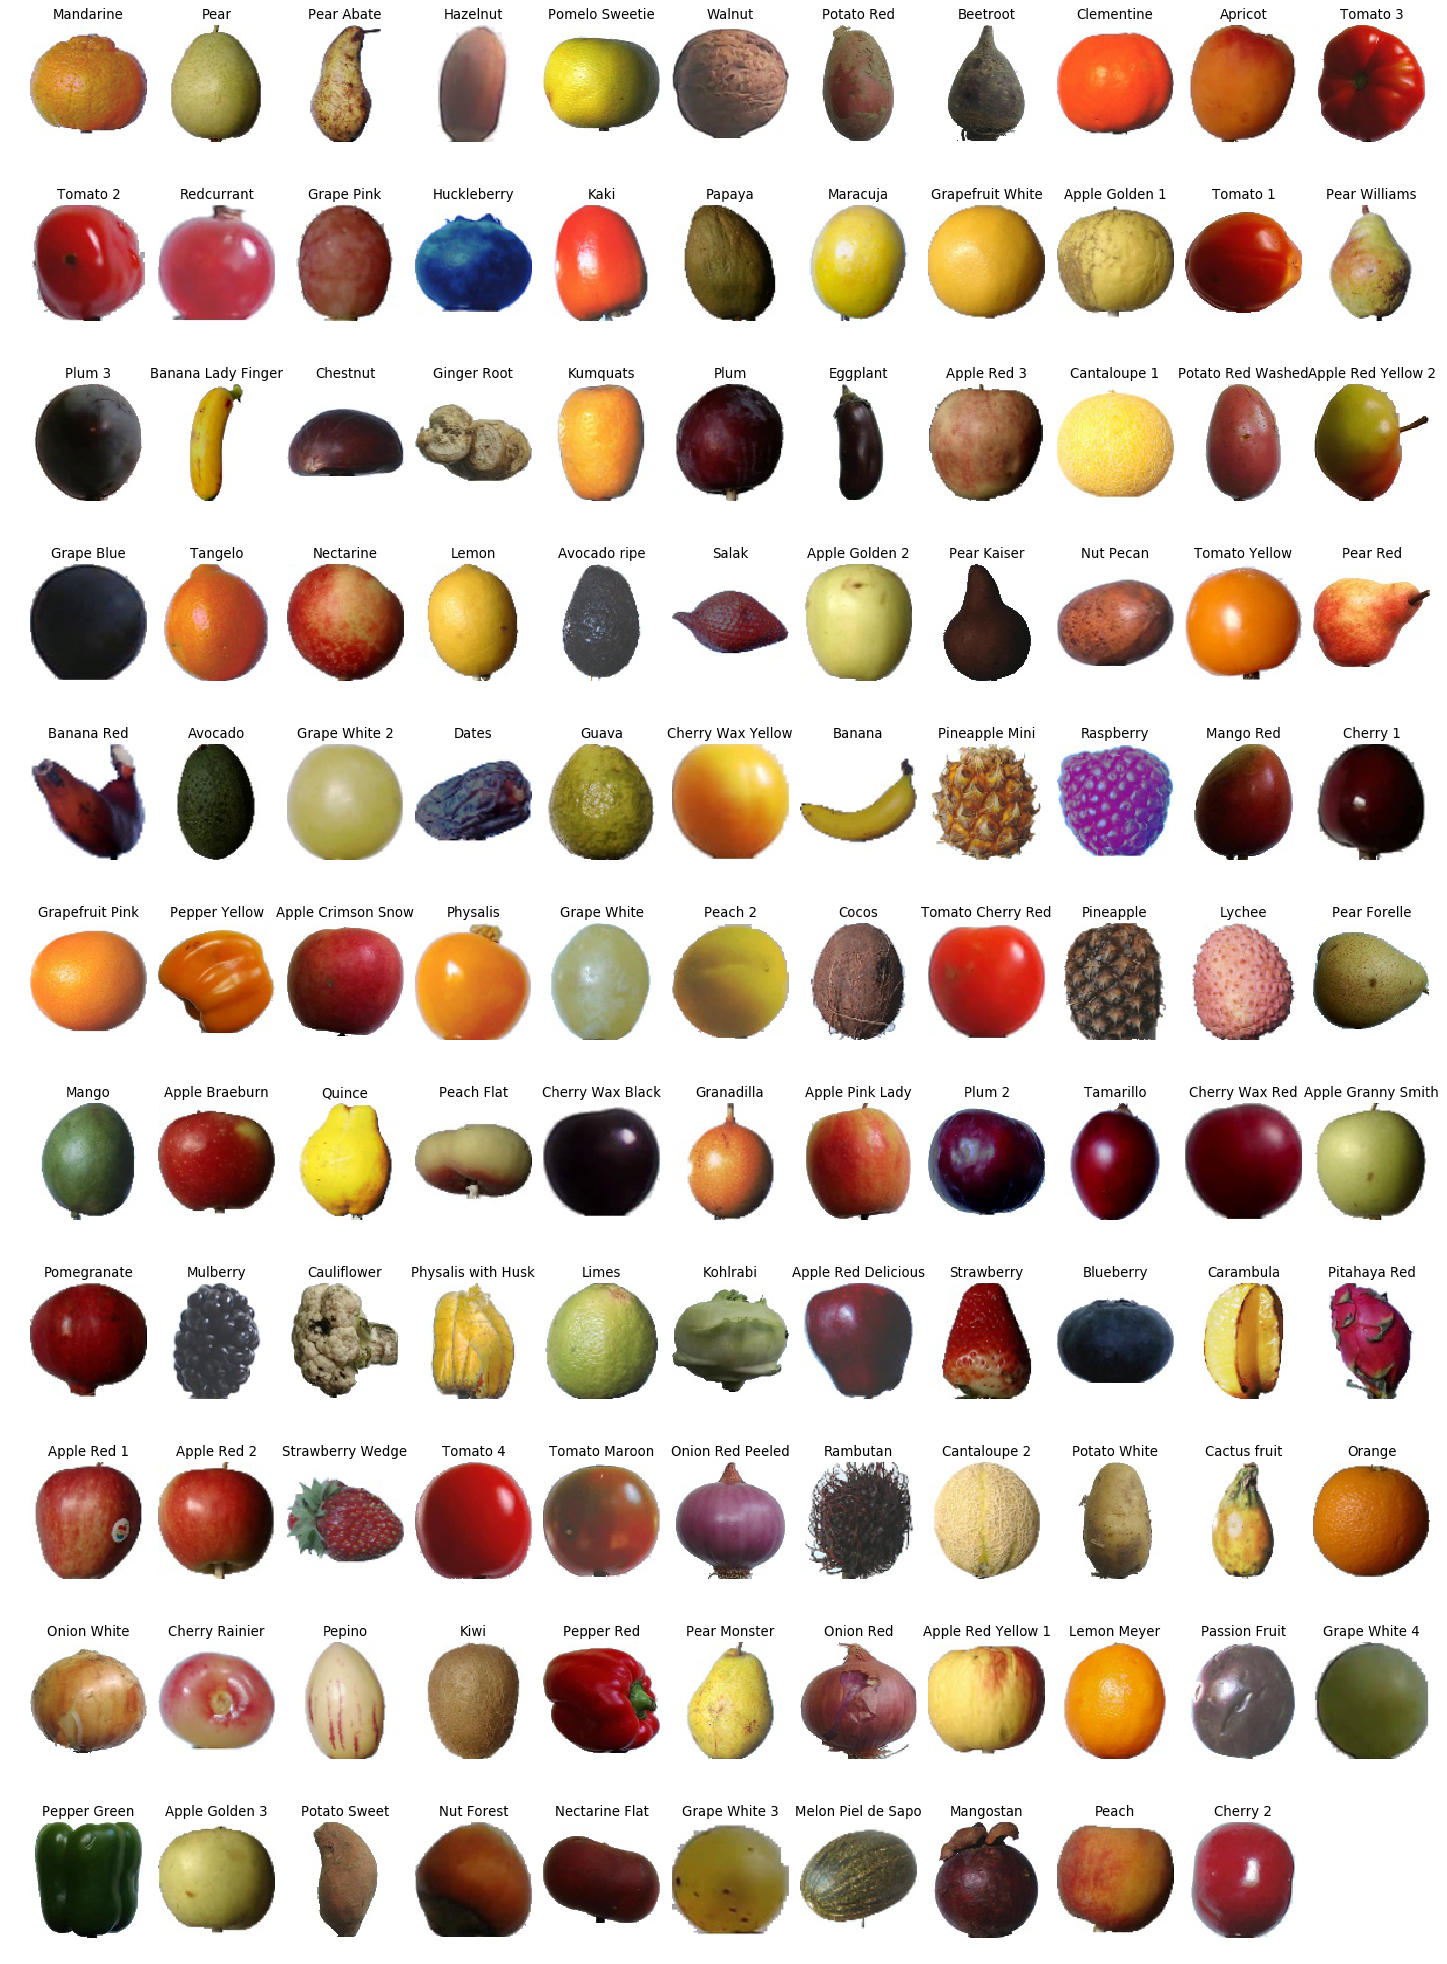

In [198]:
train_data_dir = './fruits-360/Training'      # Train directory
test_data_dir  = './fruits-360/Test'          # Test directory

plt.figure(num=None, figsize=(35, 35), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0, right=0.5, top=0.9, bottom=0.2, wspace=0.1, hspace=0.1)

i = 1
for fruit_type in os.listdir(train_data_dir):
    for fruit in os.listdir(train_data_dir+'/'+fruit_type):
        plt.subplot(11,11, i)
        img = plt.imread(train_data_dir+'/'+fruit_type+'/'+fruit)
        plt.imshow(img)
        plt.title(fruit_type)
        plt.axis('off')
        i += 1
        break;

plt.show()

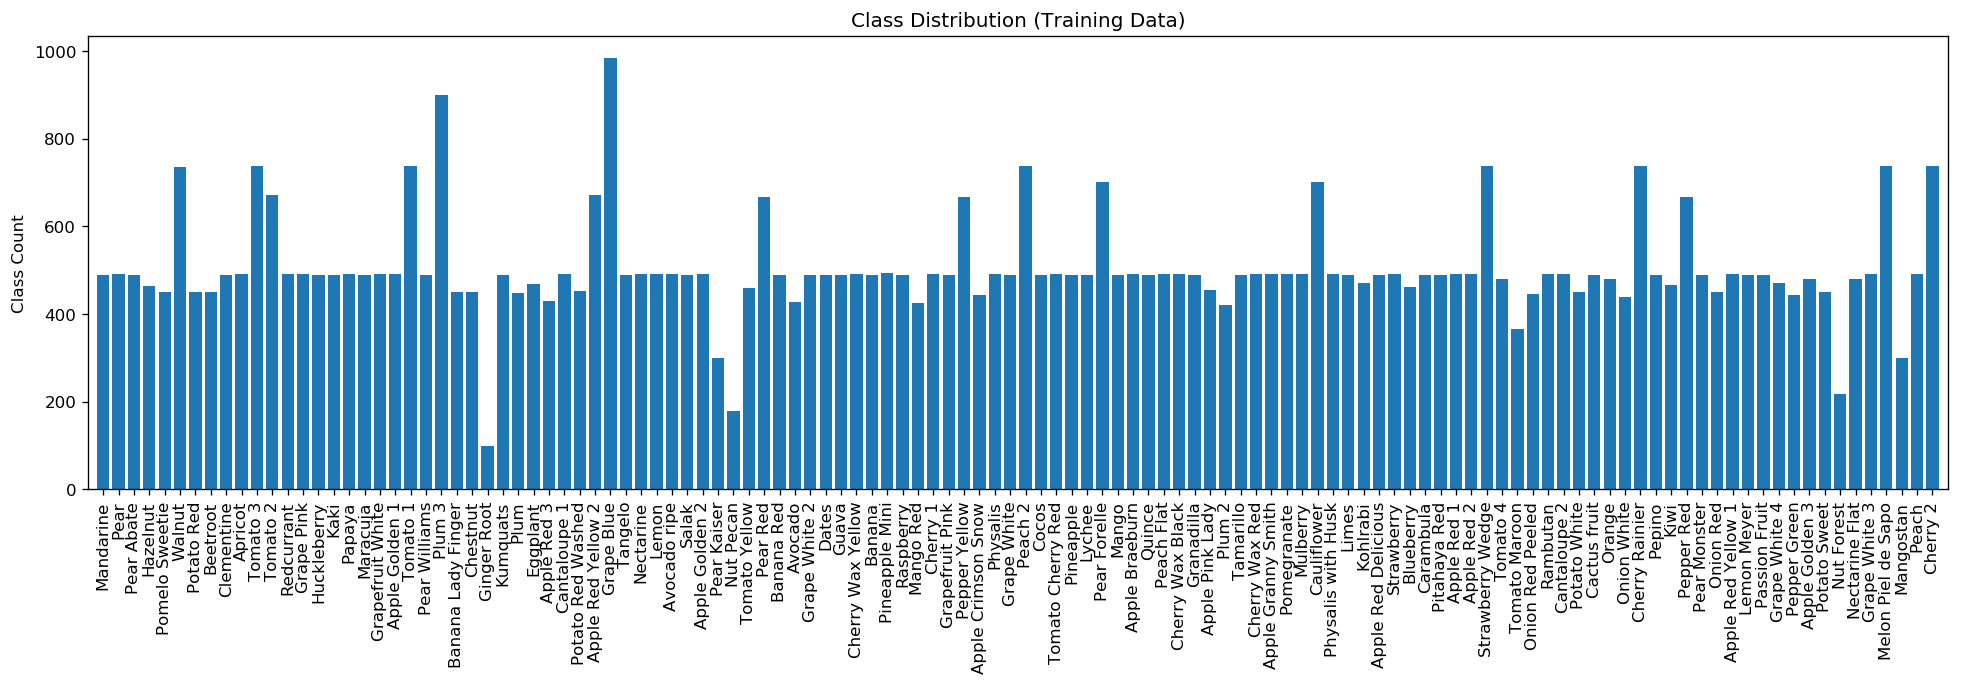

In [130]:
# creating a dictionary with number of fruits from each class
D = {}
for fruit_type in os.listdir(train_data_dir):
    D[fruit_type] = len(os.listdir(train_data_dir+'/'+fruit_type)) 
    
# plotting class distribution in training data
plt.figure(num=None, figsize=(20, 5), dpi=120, facecolor='w', edgecolor='k')
plt.bar(range(len(D)), list(D.values()), align='center');
plt.xticks(range(len(D)), list(D.keys()), rotation=90);
plt.xlim([-1, len(D)]);
plt.title('Class Distribution (Training Data)');
plt.ylabel('Class Count');

#### Preparing the Data 

We use the Keras's image augmentation API to read and prepare the data. **ImageDataGenerator** is used to fetch the data and feed it into the network in batches.

The **ImageDataGenerator** class allows for image data preparation and augmentation. Rather than saving the entire dataset and performing the network training on the entire dataset from memory, the API can be used to iterate over each minibatch in the training process while simultaneously performing the data augmentation. This greatly reduces memory requirement at the expense of slightly slower training time.

The data generator acts as an iterator, which returns batches of images from the specified directory when requested.

The data from the Train folder are split into training and validation set at an 80:20 ratio. The data from the Test folder is used for evaluating the network after the training process is complete. The training data 

In [133]:
# the process_images fuction returns the generators for training, validation and testing data
# dimX and dimY are the x and y-dimension of the images, respectively
# the batch_size is the batch size for training the network
def process_images(dimX, dimY, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255,   # normalize to [0, 1]
        zoom_range=0.2,          # apply random zoom to augment data                                  
        horizontal_flip=True,    # randomly horizontally flip some images
        validation_split=0.2)    # split data into 80:20 training:validation sets
    
    
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(dimX, dimY),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training') # set as training data

    validation_generator = train_datagen.flow_from_directory(
        train_data_dir, # same directory as training data
        target_size=(dimX, dimY),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation') # set as validation data
    
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(dimX, dimY),
        batch_size=batch_size,
        class_mode=None,  # only data, no labels
        shuffle=False)    # keep data in same order as labels
    
    return train_generator, validation_generator, test_generator

#### Model Building, Compiling and Training

We load the MobileNetV2 model with no pre-trained weights. We remove the top layer and add our own classification layer with 120 nodes (for 120 classes). 

The network is trained for 50 epochs with a batch size of 32.

In [134]:
dimX, dimY = 100, 100
batch_size = 32
nb_epochs  = 50

train_generator, validation_generator, test_generator  = process_images(dimX, dimY, batch_size)

Found 48431 images belonging to 120 classes.
Found 12067 images belonging to 120 classes.
Found 20622 images belonging to 120 classes.


In [14]:
# import MobileNetV2 without pre-trained weights. fully connected layers aren't included
mobv2 = MobileNetV2(include_top=False, input_shape=(dimX, dimY, 3), weights=None)

# add global average pooling layer
x = mobv2.output
x = GlobalAveragePooling2D()(x)

# add dropout and fully connected/classification layer (output layer)
x = Dropout(0.25)(x)
out = Dense(120, activation='softmax')(x)

# create the full network
model = Model(inputs=mobv2.input, outputs=out)

# define top 5 accuracy
def top5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# compile the model
model.compile(Adam(lr=0.01), loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top5_accuracy])

# declare checkpoint to save the best model
checkpoint = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True,
                             monitor='categorical_accuracy', mode='max')

# reduce learning rate when network stops learning
lr_reduce = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.75,
                              patience=2, verbose=1, mode='max')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 101, 101, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [7]:
# training the network
hist =  model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // batch_size,
        epochs = nb_epochs,
        verbose = 1,
        callbacks = [checkpoint, lr_reduce])

# saving the trained model
model.save('my_model.h5')

# saving the training history
history_dict = hist.history
f = open('history.pckl', 'wb')
pickle.dump(history_dict, f)
f.close()

Epoch 1/50
1513/1513 [==============================] - 155s 103ms/step - loss: 1.2851 - categorical_accuracy: 0.5941 - top5_accuracy: 0.9137 - val_loss: 89.0137 - val_categorical_accuracy: 0.0081 - val_top5_accuracy: 0.0724
Epoch 2/50
1513/1513 [==============================] - 154s 102ms/step - loss: 0.4951 - categorical_accuracy: 0.8377 - top5_accuracy: 0.9914 - val_loss: 75.2756 - val_categorical_accuracy: 0.0298 - val_top5_accuracy: 0.1258
Epoch 3/50
1513/1513 [==============================] - 148s 98ms/step - loss: 0.2948 - categorical_accuracy: 0.9040 - top5_accuracy: 0.9968 - val_loss: 68.4167 - val_categorical_accuracy: 0.0410 - val_top5_accuracy: 0.1185
Epoch 4/50
1513/1513 [==============================] - 154s 102ms/step - loss: 0.2215 - categorical_accuracy: 0.9259 - top5_accuracy: 0.9985 - val_loss: 72.5684 - val_categorical_accuracy: 0.0187 - val_top5_accuracy: 0.1092
Epoch 5/50
1513/1513 [==============================] - 155s 102ms/step - loss: 0.1690 - categorical_

Epoch 36/50
1512/1513 [============================>.] - ETA: 0s - loss: 0.0149 - categorical_accuracy: 0.9951 - top5_accuracy: 1.0000
Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.
1513/1513 [==============================] - 134s 88ms/step - loss: 0.0149 - categorical_accuracy: 0.9951 - top5_accuracy: 1.0000 - val_loss: 0.2877 - val_categorical_accuracy: 0.9581 - val_top5_accuracy: 0.9926
Epoch 37/50
1513/1513 [==============================] - 134s 89ms/step - loss: 0.0063 - categorical_accuracy: 0.9979 - top5_accuracy: 1.0000 - val_loss: 0.3043 - val_categorical_accuracy: 0.9483 - val_top5_accuracy: 0.9956
Epoch 38/50
1513/1513 [==============================] - 134s 88ms/step - loss: 0.0076 - categorical_accuracy: 0.9977 - top5_accuracy: 1.0000 - val_loss: 0.2861 - val_categorical_accuracy: 0.9540 - val_top5_accuracy: 0.9954
Epoch 39/50
1512/1513 [============================>.] - ETA: 0s - loss: 0.0090 - categorical_accuracy: 0.9973 - top5_accuracy

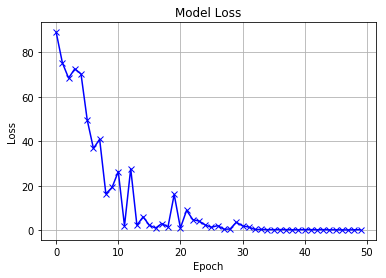

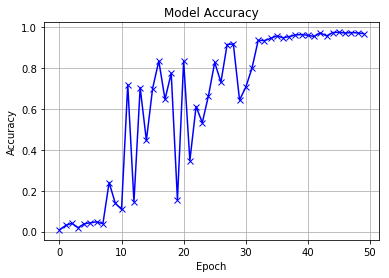

In [146]:
# plotting training history
f = open('history.pckl', 'rb')
history = pickle.load(f)
f.close()

val_loss = history['val_loss']
val_acc  = history['val_categorical_accuracy']

x = np.arange(len(val_loss))

plt.plot(x[0:], val_loss[0:], 'bx-')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(x[0:], val_acc[0:], 'bx-')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

#### Model Evaluation and Visualisation
Here we evaluate the model's accuracy on the testing dataset and we look at the cases where the model failed at predicting the correct class.

In [225]:
# Uncomment to load the trained model
'''
dependencies = {
    'top5_accuracy': top5_accuracy
}

model = load_model('my_model.h5', custom_objects=dependencies)
'''

# make predictions on the testing dataset
preds = model.predict_generator(test_generator, verbose=1)

# calculate accuracy 
tst_cls = test_generator.filenames            # class names list
tst_cls = [x.split('/')[0] for x in tst_cls]  

preds_cls_idx = preds.argmax(axis=-1) # prediction vectors
idx_to_cls = {v: k for k, v in train_generator.class_indices.items()} 
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx) # prediction class

acc = 100*sum(tst_cls == preds_cls)/len(tst_cls) # calculate accuracy
print('Accuracy: ' + str(acc))

# indices of wrong predictions
wrong_preds = [i for i, x in enumerate(tst_cls == preds_cls) if not x]

645/645 [==============================] - 11s 17ms/step
Accuracy: 99.08350305498982


Let us see one case from each class where the model fails to make the correct prediction.

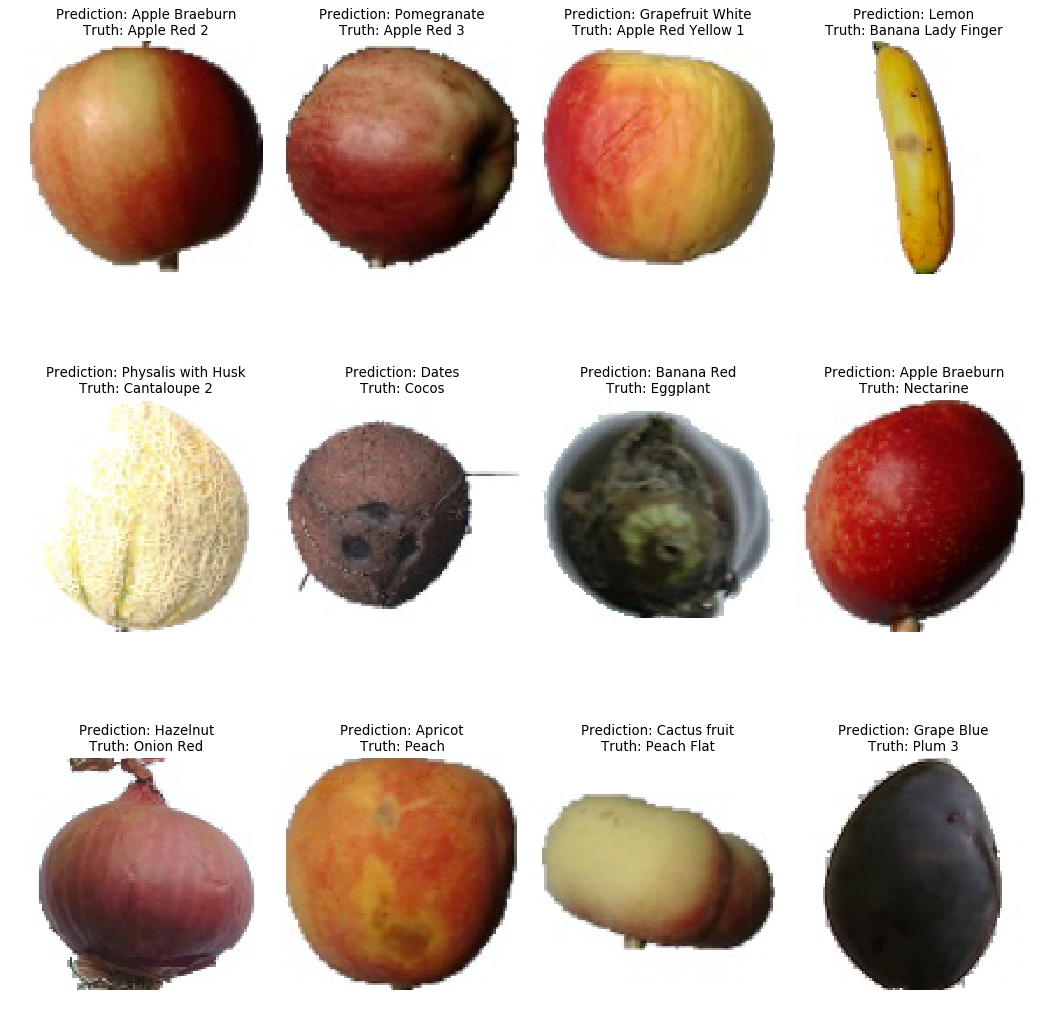

In [232]:
plt.figure(num=None, figsize=(25, 25), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0, right=0.5, top=0.9, bottom=0.2, wspace=0.1, hspace=0.1)

temp = ''
i = 1
for idx, fname in enumerate(np.array(test_generator.filenames)[wrong_preds]):
    if not fname.split('/')[0] == temp:
        img = plt.imread(test_data_dir+'/'+fname)
        plt.subplot(4, 4, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Prediction: '+ np.array(preds_cls)[wrong_preds][idx] + '\n'
                  "Truth: " + np.array(tst_cls)[wrong_preds][idx])
        temp = fname.split('/')[0]
        i+=1
    if i==13:
        break;
    else: 
        continue

plt.show()